In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('data.csv', encoding="ISO-8859-1")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
# Convert string columns to categorical
from sklearn.calibration import LabelEncoder


for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = LabelEncoder().fit_transform(data[column])

# drop the customerID column
data = data.drop('customerID', axis=1)

# drop where the TotalCharges column is empty
data = data[data['TotalCharges'] != ' ']

In [4]:
# for each column print the number of unique values, and if less than 10, print the unique values
for column in data.columns:
    print(f'{column}: {data[column].nunique()} unique values: {data[column].unique()}')

gender: 2 unique values: [0 1]
SeniorCitizen: 2 unique values: [0 1]
Partner: 2 unique values: [1 0]
Dependents: 2 unique values: [0 1]
tenure: 73 unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: 2 unique values: [0 1]
MultipleLines: 3 unique values: [1 0 2]
InternetService: 3 unique values: [0 1 2]
OnlineSecurity: 3 unique values: [0 2 1]
OnlineBackup: 3 unique values: [2 0 1]
DeviceProtection: 3 unique values: [0 2 1]
TechSupport: 3 unique values: [0 2 1]
StreamingTV: 3 unique values: [0 2 1]
StreamingMovies: 3 unique values: [0 2 1]
Contract: 3 unique values: [0 1 2]
PaperlessBilling: 2 unique values: [1 0]
PaymentMethod: 4 unique values: [2 3 0 1]
MonthlyCharges: 1585 unique values: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: 6531 unique values: [2505 1466  157 ... 2994

In [5]:
# print number of Churn==Yes vs Churn==No
print(data['Churn'].value_counts())

0    5174
1    1869
Name: Churn, dtype: int64


In [ ]:
# Train a decision tree to predict Churn using all the data
from sklearn import tree
from sklearn.model_selection import train_test_split

X = data.drop('Churn', axis=1)
Y = data['Churn']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

percentage_churn = Y_train.sum() / len(Y_train)
sample_weight = np.where(Y_train == 1, 1/percentage_churn, 1/(1-percentage_churn))

clf = tree.DecisionTreeClassifier(max_depth=14)
clf = clf.fit(X_train, Y_train, sample_weight=sample_weight)

# print the accuracy of the model
print(clf.score(X_test, Y_test))

0.7253371185237757


In [7]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, Y_train, sample_weight=sample_weight)

# print the accuracy of the model
print(clf.score(X_test, Y_test))

0.7984386089425124


In [8]:
# Find out the most important features in X_train
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    column_name = X_train.columns[indices[f]]
    print("%d. feature %s (%f)" % (f + 1, column_name, importances[indices[f]]))

1. feature tenure (0.170027)
2. feature MonthlyCharges (0.164348)
3. feature TotalCharges (0.151713)
4. feature Contract (0.107689)
5. feature TechSupport (0.061138)
6. feature OnlineSecurity (0.055462)
7. feature PaymentMethod (0.049465)
8. feature OnlineBackup (0.025976)
9. feature gender (0.025448)
10. feature PaperlessBilling (0.024746)
11. feature InternetService (0.023983)
12. feature DeviceProtection (0.023436)
13. feature MultipleLines (0.020572)
14. feature Partner (0.020276)
15. feature Dependents (0.018944)
16. feature StreamingMovies (0.017625)
17. feature SeniorCitizen (0.017447)
18. feature StreamingTV (0.016254)
19. feature PhoneService (0.005451)


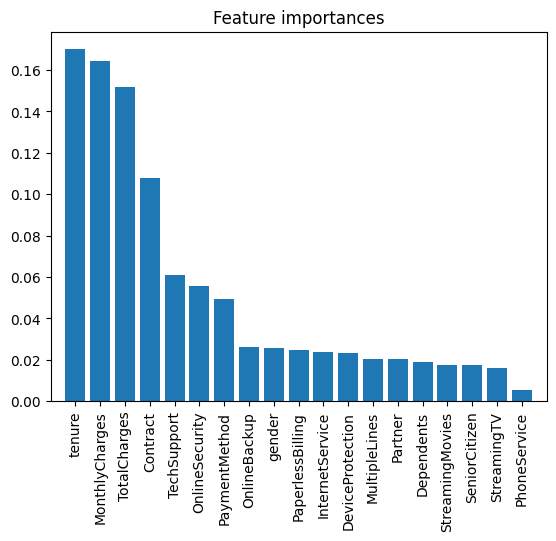

In [9]:
# Plot the feature importances with the column names
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [11]:
# Train a decision tree to predict Churn using only the 5 most important features
X_train_important = X_train[X_train.columns[indices[:5]]]
X_test_important = X_test[X_test.columns[indices[:5]]]

percentage_churn = Y_train.sum() / len(Y_train)
sample_weight = np.where(Y_train == 1, 1/percentage_churn, 1/(1-percentage_churn))

clf_important = RandomForestClassifier()
clf_important = clf_important.fit(X_train_important, Y_train, sample_weight=sample_weight)

# print the accuracy of the model
print(clf_important.score(X_test_important, Y_test))

0.7672107877927609


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import StandardScaler

scalar = StandardScaler()
scaled_X_train = scalar.fit_transform(X_train)
scaled_X_test = scalar.transform(X_test)

# Logistic Regression
clf = LogisticRegression()
clf = clf.fit(scaled_X_train, Y_train)

# print the accuracy of the model
print(clf.score(scaled_X_test, Y_test))

0.8055358410220014


In [14]:
# Logistic Regression with only the 5 most important features
scalar = StandardScaler()
scaled_X_train_important = scalar.fit_transform(X_train_important)
scaled_X_test_important = scalar.transform(X_test_important)

clf_important = LogisticRegression()
clf_important = clf_important.fit(scaled_X_train_important, Y_train)

print(clf_important.score(scaled_X_test_important, Y_test))

0.7892122072391767
